In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

import seaborn as sns

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [2]:
data = pd.read_csv('Data/player_stats_cleaned.csv')
data.head()

,id,name,dateOfBirth,Age,Height,Foot,Position,OtherPosition,National,MarketValue,...,25A,25MP,25AP,Ranking,2020AvgMV,2021AvgMV,2022AvgMV,2023AvgMV,2024AvgMV,TotalCups
0,591949,Aaron Hickey,"Jun 10, 2002",22,1.85,both,Right-Back,"['Left-Back', 'Left Midfield']",Scotland,22000000.0,...,0,0.0,0,432.000,1.845000e+06,8.666667e+06,17000000.0,2.833333e+07,2.500000e+07,0
1,434207,Aaron Connolly,"Jan 28, 2000",25,1.74,right,Centre-Forward,['Second Striker'],Ireland,2500000.0,...,0,505.0,14,3.644,5.500000e+06,7.000000e+06,5500000.0,3.500000e+06,2.500000e+06,2
2,578459,Aaron Bastiaans,"Apr 4, 2002",22,1.84,right,Left Winger,"['Right Winger', 'Centre-Forward']",Netherlands,0.0,...,0,0.0,0,0.000,1.500000e+05,1.250000e+05,175000.0,0.000000e+00,0.000000e+00,0
3,884244,AJ Marcucci,"Jul 31, 1999",25,1.91,hand,Goalkeeper,[],United States,250000.0,...,0,0.0,0,0.000,0.000000e+00,1.000000e+05,125000.0,1.500000e+05,2.166667e+05,0
4,401362,Aarón Herrera,"Jun 6, 1997",27,1.80,right,Right-Back,"['Left-Back', 'Right Midfield']",United States,2000000.0,...,0,0.0,0,4.274,9.666667e+05,1.600000e+06,2000000.0,2.000000e+06,2.000000e+06,1


In [3]:
df = data.drop(['name', 'dateOfBirth', 'National', 'OtherPosition','ContractOption','ContractExpiry', 'id'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12952 entries, 0 to 12951
Data columns (total 56 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          12952 non-null  int64  
 1   Height       12952 non-null  float64
 2   Foot         12952 non-null  object 
 3   Position     12952 non-null  object 
 4   MarketValue  12952 non-null  float64
 5   Outfitter    3058 non-null   object 
 6   Club_name    12952 non-null  object 
 7   20YC         12952 non-null  int64  
 8   20YC2        12952 non-null  int64  
 9   20RC         12952 non-null  int64  
 10  20G          12952 non-null  int64  
 11  20A          12952 non-null  int64  
 12  20MP         12952 non-null  float64
 13  20AP         12952 non-null  int64  
 14  21YC         12952 non-null  int64  
 15  21YC2        12952 non-null  int64  
 16  21RC         12952 non-null  int64  
 17  21G          12952 non-null  int64  
 18  21A          12952 non-null  int64  
 19  21MP

In [4]:
# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[numeric_cols])

# Apply PCA with different numbers of components
pca_2 = PCA(n_components=2)
pca_3 = PCA(n_components=3)
pca_full = PCA()

principal_components_2 = pca_2.fit_transform(data_scaled)
principal_components_3 = pca_3.fit_transform(data_scaled)
principal_components_full = pca_full.fit_transform(data_scaled)

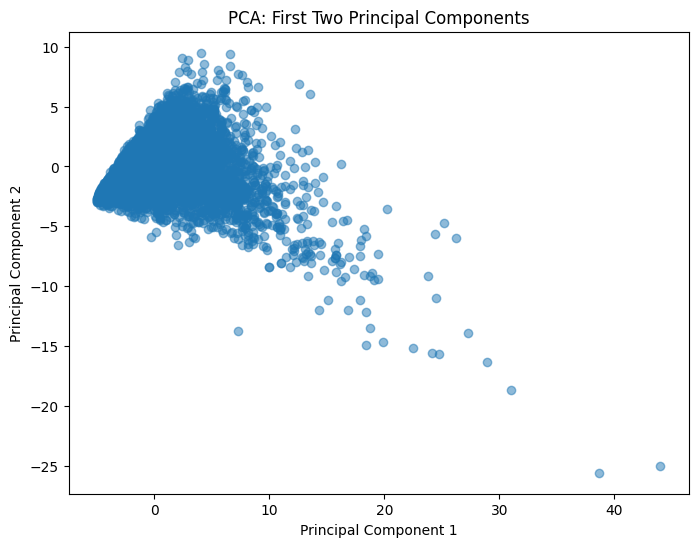

In [5]:
# Scatter plot of first two principal components
plt.figure(figsize=(8,6))
plt.scatter(principal_components_2[:, 0], principal_components_2[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: First Two Principal Components')
plt.show()

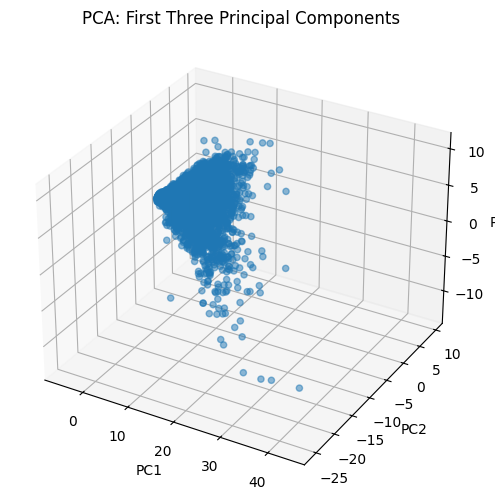

In [6]:
# 3D scatter plot of first three principal components
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(principal_components_3[:, 0], principal_components_3[:, 1], principal_components_3[:, 2], alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA: First Three Principal Components')
plt.show()

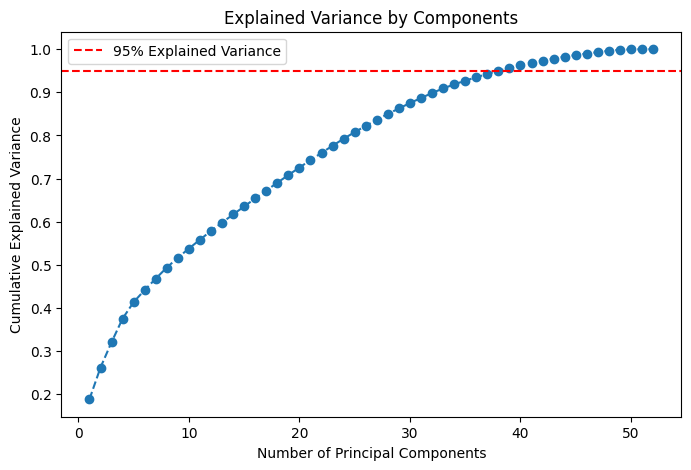

Number of components for 95% explained variance: 39


In [7]:
# Explained variance ratio
explained_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_95 = np.argmax(explained_variance >= 0.95) + 1  # Find components for 95% variance

# Plot cumulative explained variance
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.legend()
plt.show()

print(f'Number of components for 95% explained variance: {n_components_95}')

In [8]:
pca_95 = PCA(n_components=n_components_95)
data_for_clustering = pca_95.fit_transform(data_scaled)
 
data_for_clustering.shape

(12952, 39)

In [9]:
# Get eigenvalues from the full PCA
eigenvalues = pca_full.explained_variance_

# Display the top 3 eigenvalues
print("Top 3 eigenvalues:")
for i in range(3):
    print(f"Eigenvalue {i+1}: {eigenvalues[i]:.4f}")

Top 3 eigenvalues:
Eigenvalue 1: 9.7701
Eigenvalue 2: 3.8277
Eigenvalue 3: 3.0569


### K-Means Clustering

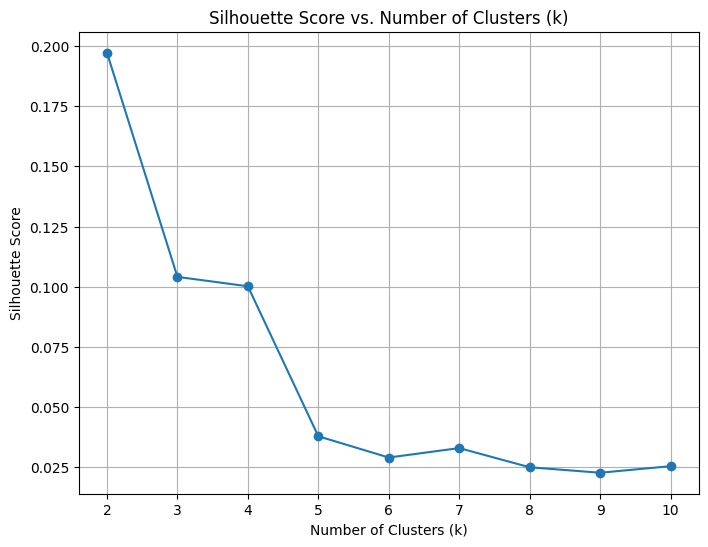

In [10]:
# Silhouette Method for k selection
silhouette_scores = []
possible_k_values = range(2, 11)  # Test k from 2 to 10

for k in possible_k_values:
    kmeans = KMeans(n_clusters=k, random_state=1911, n_init = 'auto')
    cluster_labels = kmeans.fit_predict(data_for_clustering)
    silhouette_avg = silhouette_score(data_for_clustering, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(possible_k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

<Figure size 800x600 with 0 Axes>

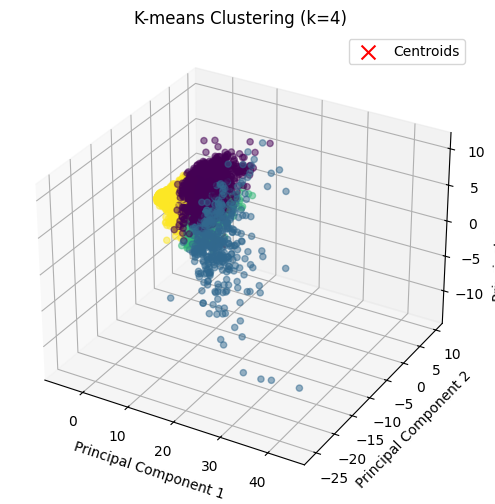


--- Market Value Analysis for k=4 ---
                          mean      median           std  count  min  \
kmeans_cluster_4                                                       
0                 4.258093e+06   1500000.0  6.863090e+06   2564  0.0   
1                 3.726516e+07  30000000.0  3.031412e+07    399  0.0   
2                 2.632097e+06    800000.0  5.410552e+06   4148  0.0   
3                 1.027634e+06    225000.0  3.293389e+06   5841  0.0   

                          max  
kmeans_cluster_4               
0                  60000000.0  
1                 200000000.0  
2                  55000000.0  
3                  70000000.0  


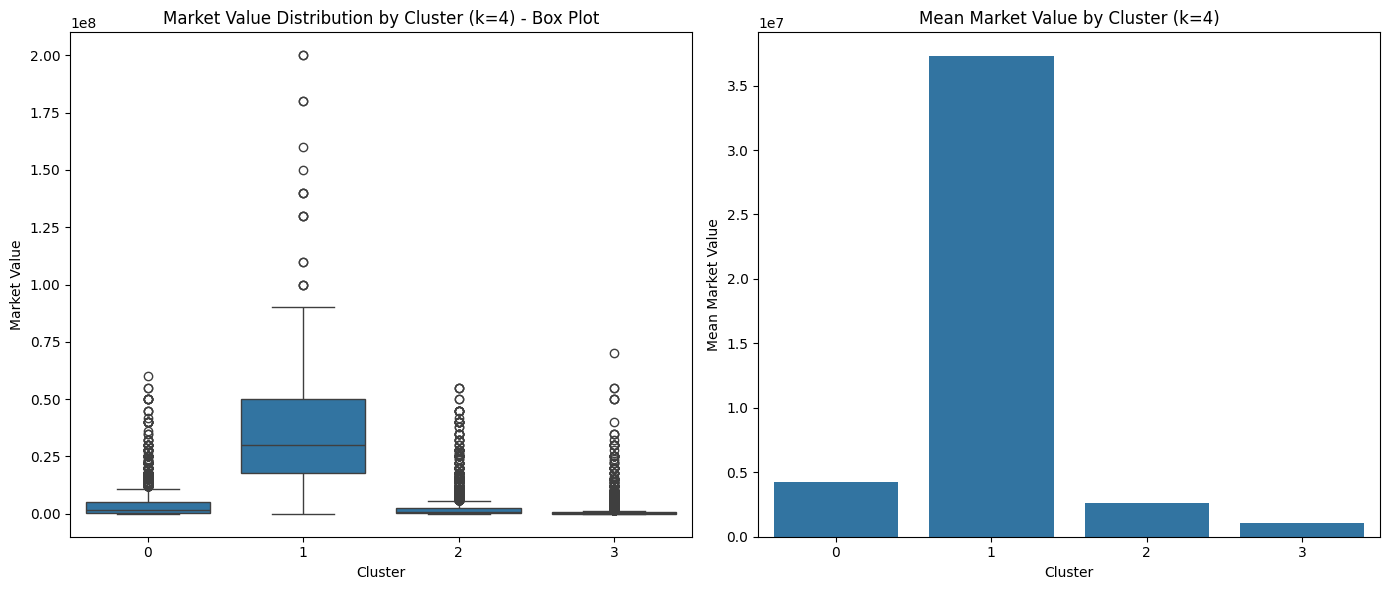

<Figure size 800x600 with 0 Axes>

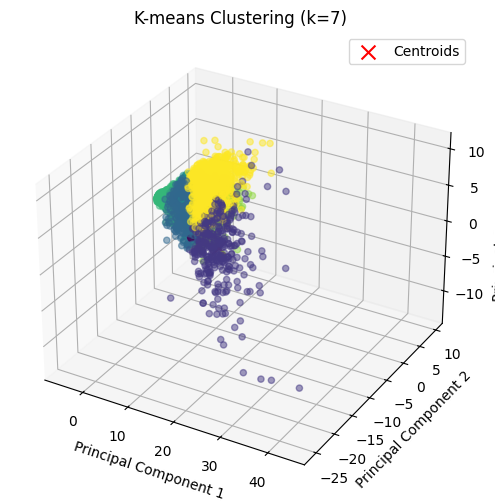


--- Market Value Analysis for k=7 ---
                          mean      median           std  count  min  \
kmeans_cluster_7                                                       
0                 2.286096e+06    600000.0  5.247828e+06    748  0.0   
1                 4.125799e+07  35000000.0  3.200126e+07    319  0.0   
2                 3.590506e+06    850000.0  7.355122e+06   2699  0.0   
3                 8.514867e+05    350000.0  1.764009e+06   3010  0.0   
4                 4.981812e+05    125000.0  1.490811e+06   2782  0.0   
5                 3.107311e+06   1200000.0  5.435788e+06   1759  0.0   
6                 5.339541e+06   2200000.0  7.777065e+06   1635  0.0   

                          max  
kmeans_cluster_7               
0                  45000000.0  
1                 200000000.0  
2                  70000000.0  
3                  30000000.0  
4                  20000000.0  
5                  50000000.0  
6                  65000000.0  


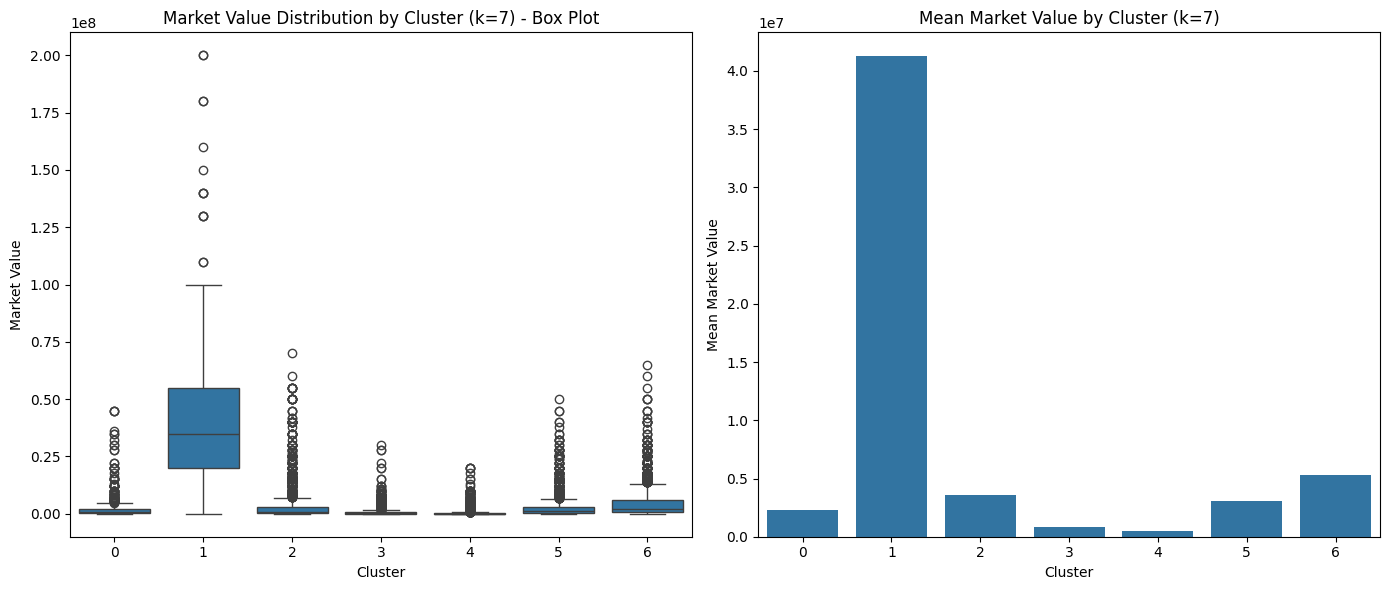

<Figure size 800x600 with 0 Axes>

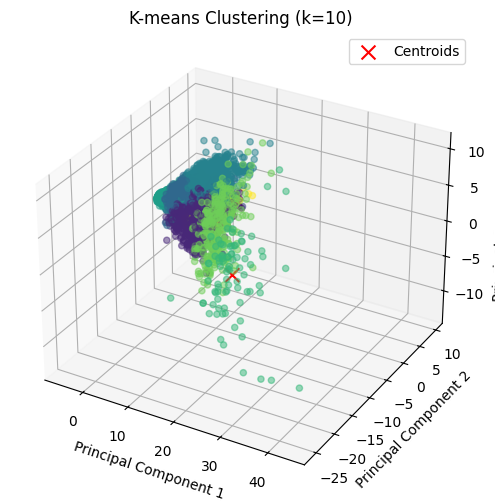


--- Market Value Analysis for k=10 ---
                           mean      median           std  count         min  \
kmeans_cluster_10                                                              
0                  1.420297e+06    550000.0  2.160874e+06    707         0.0   
1                  2.231023e+07  18000000.0  1.138815e+07    577  12000000.0   
2                  1.459735e+06    550000.0  2.313895e+06    697         0.0   
3                  1.517102e+06    600000.0  2.353497e+06   2678         0.0   
4                  2.729684e+06   1500000.0  3.484084e+06   1441         0.0   
5                  3.760166e+05    100000.0  9.962751e+05   3138         0.0   
6                  7.221176e+07  60000000.0  4.209063e+07     85   9000000.0   
7                  2.289797e+07  20000000.0  1.616478e+07    345         0.0   
8                  1.428517e+06    600000.0  1.965226e+06   2606         0.0   
9                  1.291423e+06    500000.0  2.014881e+06    678         0.0   


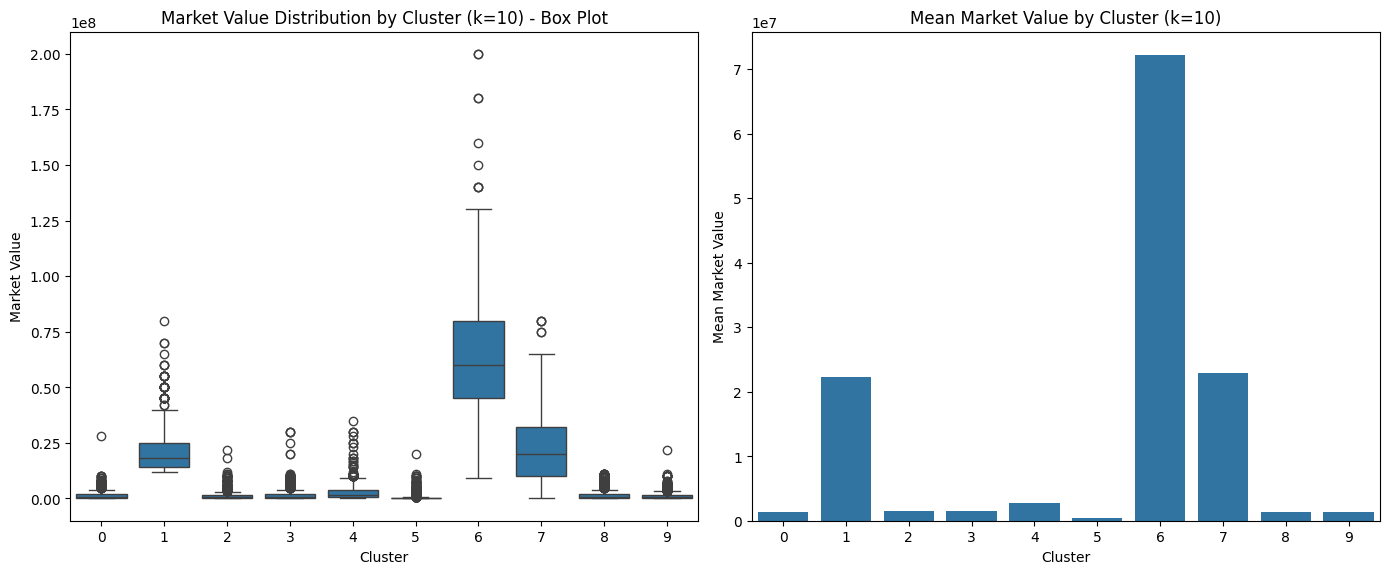

In [11]:
k_values = [4, 7, 10]
kmeans_models = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(data_for_clustering)
    kmeans_models[k] = kmeans
    df[f'kmeans_cluster_{k}'] = cluster_labels

    # Plotting (as before)
    plt.figure(figsize=(8, 6))
    if data_for_clustering.shape[1] == 2:
        plt.scatter(data_for_clustering[:, 0], data_for_clustering[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
        plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100, label='Centroids')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
    elif data_for_clustering.shape[1] >= 3:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(data_for_clustering[:, 0], data_for_clustering[:, 1], data_for_clustering[:, 2], c=cluster_labels, cmap='viridis', alpha=0.5)
        ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], c='red', marker='x', s=100, label='Centroids')
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_zlabel('Principal Component 3')
    plt.title(f'K-means Clustering (k={k})')
    plt.legend()
    plt.show()

    # Market Value Analysis (with box plot and bar plot)
    print(f"\n--- Market Value Analysis for k={k} ---")
    cluster_stats = df.groupby(f'kmeans_cluster_{k}')['MarketValue'].agg(['mean', 'median', 'std', 'count', 'min', 'max'])
    print(cluster_stats)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Box Plot
    sns.boxplot(x=f'kmeans_cluster_{k}', y='MarketValue', data=df, ax=axes[0])
    axes[0].set_title(f'Market Value Distribution by Cluster (k={k}) - Box Plot')
    axes[0].set_xlabel('Cluster')
    axes[0].set_ylabel('Market Value')

    # Bar Plot (Mean Market Value)
    sns.barplot(x=cluster_stats.index, y=cluster_stats['mean'], ax=axes[1])
    axes[1].set_title(f'Mean Market Value by Cluster (k={k})')
    axes[1].set_xlabel('Cluster')
    axes[1].set_ylabel('Mean Market Value')

    plt.tight_layout()
    plt.show()

### Hierarchical Clustering

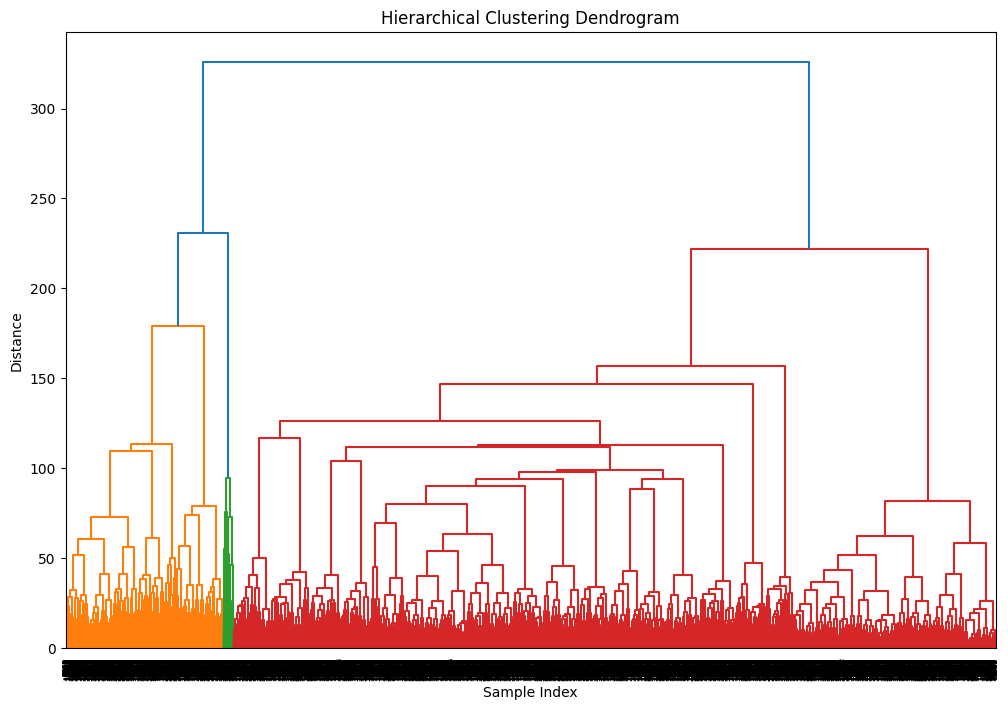


--- Market Value Analysis for Hierarchical Clustering (n_clusters=7) ---
                              mean      median           std  count  \
hierarchical_cluster                                                  
0                     1.416644e+06    500000.0  2.352728e+06   6978   
1                     3.493910e+06   1500000.0  5.036376e+06   1527   
2                     5.570714e+07  50000000.0  4.111455e+07    140   
3                     5.342215e+05    150000.0  1.289684e+06   2826   
4                     2.405349e+07  20000000.0  1.238931e+07    673   
5                     3.672035e+06    800000.0  7.563668e+06    371   
6                     1.435526e+06    550000.0  2.239843e+06    437   

                            min          max  
hierarchical_cluster                          
0                           0.0   30000000.0  
1                           0.0   40000000.0  
2                           0.0  200000000.0  
3                           0.0   11000000.0  
4   

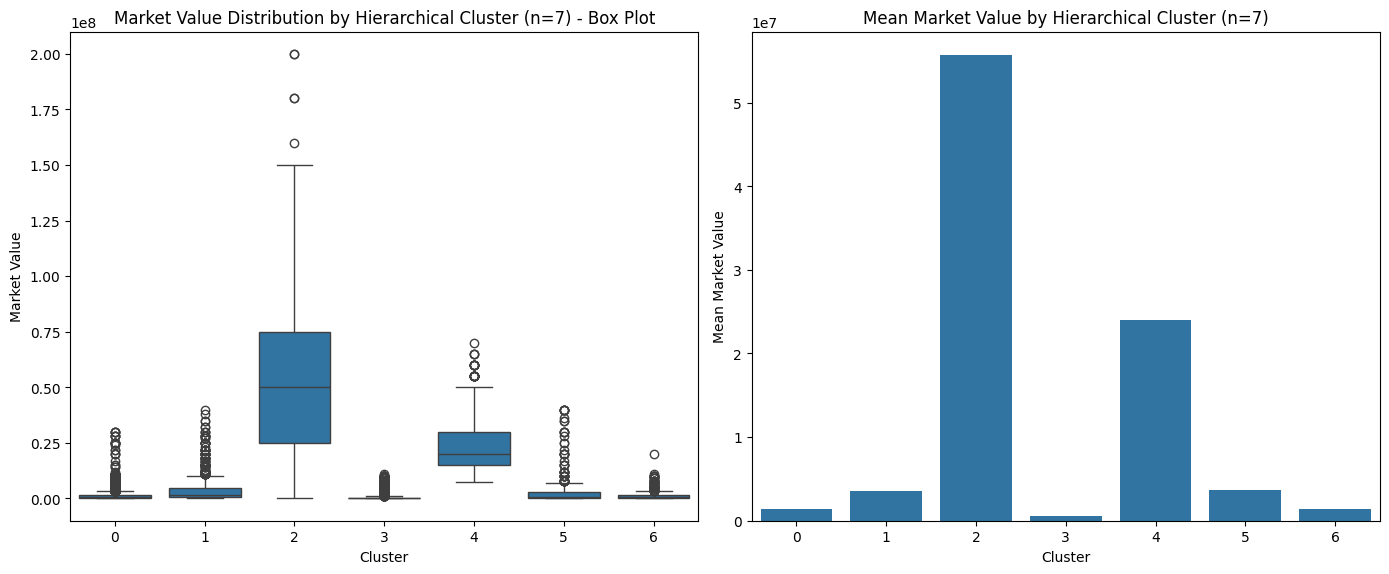

In [12]:
linked = linkage(data_for_clustering, method='ward')
plt.figure(figsize=(12, 8))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

n_clusters_hierarchical = 7
hierarchical = AgglomerativeClustering(n_clusters=n_clusters_hierarchical, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(data_for_clustering)
df['hierarchical_cluster'] = hierarchical_labels

print(f"\n--- Market Value Analysis for Hierarchical Clustering (n_clusters={n_clusters_hierarchical}) ---")
cluster_stats = df.groupby('hierarchical_cluster')['MarketValue'].agg(['mean', 'median', 'std', 'count', 'min', 'max'])
print(cluster_stats)


# Create subplots (Box plot and Bar plot)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box Plot
sns.boxplot(x='hierarchical_cluster', y='MarketValue', data=df, ax=axes[0])
axes[0].set_title(f'Market Value Distribution by Hierarchical Cluster (n={n_clusters_hierarchical}) - Box Plot')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Market Value')

# Bar Plot (Mean Market Value)
sns.barplot(x=cluster_stats.index, y=cluster_stats['mean'], ax=axes[1])
axes[1].set_title(f'Mean Market Value by Hierarchical Cluster (n={n_clusters_hierarchical})')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Mean Market Value')


plt.tight_layout()
plt.show()

### DBSCAN Clustering


--- DBSCAN Results ---
Estimated number of clusters: 8
Estimated number of noise points: 1465


<Figure size 800x600 with 0 Axes>

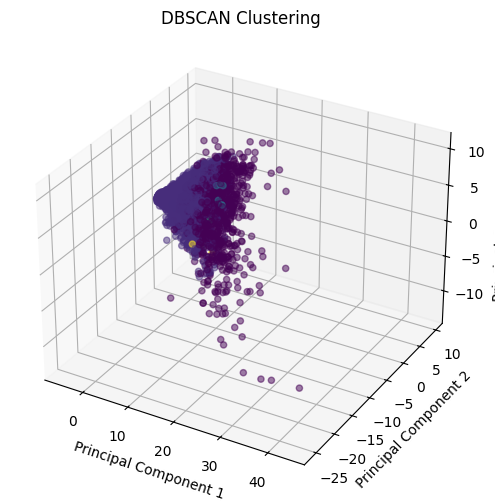


--- Market Value Analysis for DBSCAN ---
                        mean      median           std  count         min  \
dbscan_cluster                                                              
-1              1.342328e+07   4000000.0  2.219048e+07   1465         0.0   
 0              1.979006e+06    450000.0  4.831994e+06  11463         0.0   
 1              3.000000e+05    400000.0  2.645751e+05      3         0.0   
 2              1.533333e+07  13500000.0  1.189398e+07      6   4000000.0   
 3              6.000000e+06   6000000.0  0.000000e+00      3   6000000.0   
 4              3.500000e+07  35000000.0  0.000000e+00      3  35000000.0   
 5              1.200000e+07  12000000.0  0.000000e+00      3  12000000.0   
 6              3.850000e+06   4000000.0  3.227615e+06      3    550000.0   
 7              3.100000e+07  30000000.0  3.605551e+06      3  28000000.0   

                        max  
dbscan_cluster               
-1              200000000.0  
 0               700

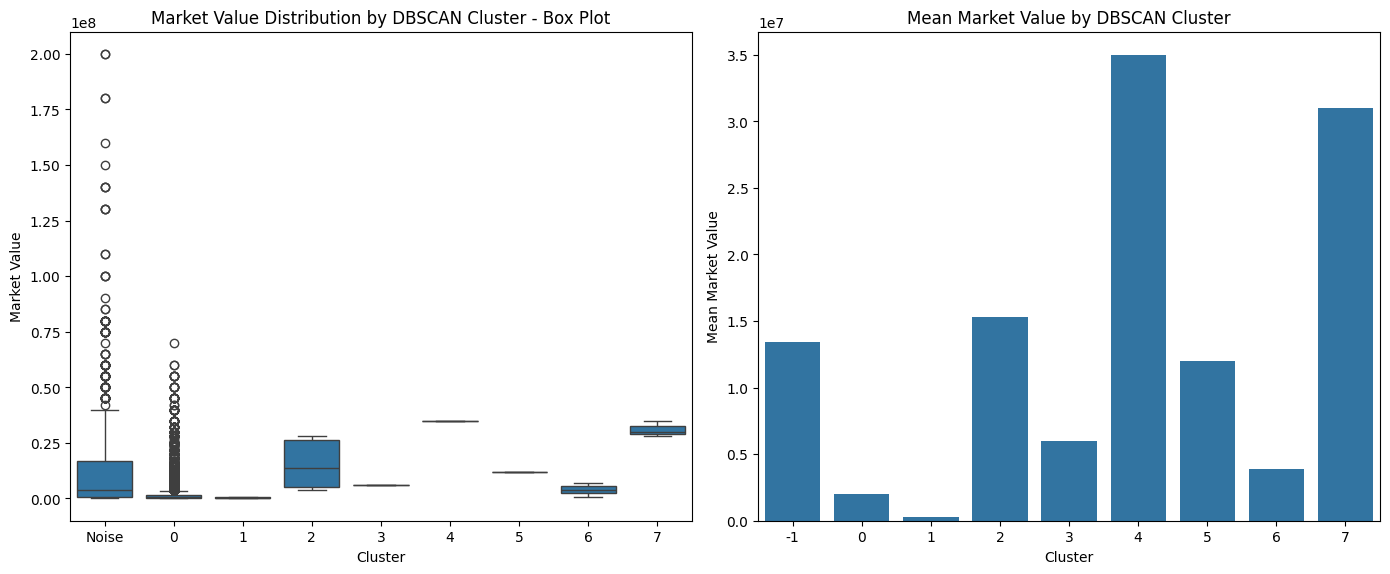

In [13]:
dbscan = DBSCAN(eps=6, min_samples=3)  # Adjust eps and min_samples!
dbscan_labels = dbscan.fit_predict(data_for_clustering)
df['dbscan_cluster'] = dbscan_labels

n_clusters_ = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_ = list(dbscan_labels).count(-1)

print("\n--- DBSCAN Results ---")
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

plt.figure(figsize=(8, 6))
if data_for_clustering.shape[1] == 2:
    plt.scatter(data_for_clustering[:, 0], data_for_clustering[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.5)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
elif data_for_clustering.shape[1] >= 3:
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data_for_clustering[:, 0], data_for_clustering[:, 1], data_for_clustering[:, 2], c=dbscan_labels, cmap='viridis', alpha=0.5)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
plt.title('DBSCAN Clustering')
plt.show()

print("\n--- Market Value Analysis for DBSCAN ---")
cluster_stats = df.groupby('dbscan_cluster')['MarketValue'].agg(['mean', 'median', 'std', 'count', 'min', 'max'])
print(cluster_stats)

# Create subplots (Box plot and Bar plot)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Handle potential missing clusters (e.g., only noise points)
if -1 in cluster_stats.index:
    df['dbscan_cluster'] = df['dbscan_cluster'].replace({-1: 'Noise'})

# Box Plot
sns.boxplot(x='dbscan_cluster', y='MarketValue', data=df, ax=axes[0])
axes[0].set_title('Market Value Distribution by DBSCAN Cluster - Box Plot')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Market Value')

# Bar Plot (Mean Market Value)
#Handle the situation when there is only noise
if cluster_stats.shape[0] > 1:
    sns.barplot(x=cluster_stats.index, y=cluster_stats['mean'], ax=axes[1])
    axes[1].set_title('Mean Market Value by DBSCAN Cluster')
    axes[1].set_xlabel('Cluster')
    axes[1].set_ylabel('Mean Market Value')
else:
  axes[1].text(0.5, 0.5, 'Only noise points detected', horizontalalignment='center',verticalalignment='center', transform=axes[1].transAxes)

plt.tight_layout()
plt.show()

### ARM

In [ ]:
#Get only categorical columns
categorical_df = data[data.select_dtypes(include=['object']).columns]
# Convert categorical data to boolean type
categorical_encoded = pd.get_dummies(categorical_df)

# Generate frequent itemsets
frequent_itemsets = apriori(categorical_encoded, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Sort rules by lift
rules = rules.sort_values('lift', ascending=False)

# Display top 10 rules
print("\nTop 10 Association Rules:")
print(rules.head(10))



Top 10 Association Rules:
                                           antecedents  \
99                       (OtherPosition_['Left-Back'])   
100       (Foot_left, OtherPosition_['Left Midfield'])   
102                  (OtherPosition_['Left Midfield'])   
70                   (OtherPosition_['Left Midfield'])   
71   (OtherPosition_['Left Winger', 'Attacking Midf...   
68   (OtherPosition_['Right Winger', 'Centre-Forwar...   
67   (OtherPosition_['Right Winger', 'Attacking Mid...   
156   (Foot_right, OtherPosition_['Central Midfield'])   
157               (OtherPosition_['Central Midfield'])   
65                (OtherPosition_['Central Midfield'])   

                                   consequents  antecedent support  \
99           (Position_Centre-Back, Foot_left)            0.028876   
100                       (Position_Left-Back)            0.019765   
102            (Foot_left, Position_Left-Back)            0.020846   
70                        (Position_Left-Back)        